In [1]:
import pandas as pd
import numpy as np
import json
import urllib.request as r
from PIL import Image
import torch
import clip

D:\Anaconda\envs\test\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_parquet('product_images.parquet')

In [3]:
df.head()

,asin,title,primary_image
0,B0B7NV73PJ,SanDisk 256GB Ultra microSDXC UHS-I Memory Car...,https://m.media-amazon.com/images/I/41MpKnSAd0...
1,B0B7NVXLLM,SanDisk 512GB Ultra microSDXC UHS-I Memory Car...,https://m.media-amazon.com/images/I/41ikVLl+gp...
2,B0B985Q9F1,SanDisk 256GB microSDXC -Card Licensed for Nin...,https://m.media-amazon.com/images/I/51X0sUzOQ7...
3,B071FVF3T7,Zinus 6 Inch Green Tea Memory Foam Mattress / ...,https://m.media-amazon.com/images/I/51t3X6VyK+...
4,B00Q7EPY04,Zinus 12 Inch Green Tea Memory Foam Mattress /...,https://m.media-amazon.com/images/I/51tBWhJnUF...


In [4]:
df=df[df["primary_image"].str.endswith(".jpg")|df["primary_image"].str.endswith(".png")].rename(columns={"asin":"id"})

In [5]:
df

,id,title,primary_image
0,B0B7NV73PJ,SanDisk 256GB Ultra microSDXC UHS-I Memory Car...,https://m.media-amazon.com/images/I/41MpKnSAd0...
1,B0B7NVXLLM,SanDisk 512GB Ultra microSDXC UHS-I Memory Car...,https://m.media-amazon.com/images/I/41ikVLl+gp...
2,B0B985Q9F1,SanDisk 256GB microSDXC -Card Licensed for Nin...,https://m.media-amazon.com/images/I/51X0sUzOQ7...
3,B071FVF3T7,Zinus 6 Inch Green Tea Memory Foam Mattress / ...,https://m.media-amazon.com/images/I/51t3X6VyK+...
4,B00Q7EPY04,Zinus 12 Inch Green Tea Memory Foam Mattress /...,https://m.media-amazon.com/images/I/51tBWhJnUF...
...,...,...,...
99995,B07R3K2F94,QuiFit Motivational Gallon Water Bottle - with...,https://m.media-amazon.com/images/I/516qh9MKbC...
99996,B084GRZGBN,Leemax VibroComf Neck Pillow for Traveling Was...,https://m.media-amazon.com/images/I/41v2nairg4...
99997,B08MTSW5KB,FESHFEN Invisible Wire Hair Extensions with Tr...,https://m.media-amazon.com/images/I/41AGbpZHAj...
99998,B094DL8WD7,Gua Sha Massage Tools Set Aventurine Natural g...,https://m.media-amazon.com/images/I/312VuAOYZl...


In [6]:
df['primary_image'].values

array(['https://m.media-amazon.com/images/I/41MpKnSAd0L._SL500_.jpg',
       'https://m.media-amazon.com/images/I/41ikVLl+gpL._SL500_.jpg',
       'https://m.media-amazon.com/images/I/51X0sUzOQ7L._SL500_.jpg', ...,
       'https://m.media-amazon.com/images/I/41AGbpZHAjL._SL500_.jpg',
       'https://m.media-amazon.com/images/I/312VuAOYZlS._SL500_.jpg',
       'https://m.media-amazon.com/images/I/21fb5XoXcOL._SL500_.jpg'],
      dtype=object)

In [7]:
img = r.urlretrieve(df['primary_image'].values[0])
text = df['title'].values[0]

In [8]:
img

('C:\\Users\\bardd\\AppData\\Local\\Temp\\tmpgbispf8u',
 <http.client.HTTPMessage at 0x28cccbc1dc0>)

In [9]:
text

'SanDisk 256GB Ultra microSDXC UHS-I Memory Card with Adapter - Up to 150MB/s, C10, U1, Full HD, A1, MicroSD Card - SDSQUAC-256G-GN6MA'

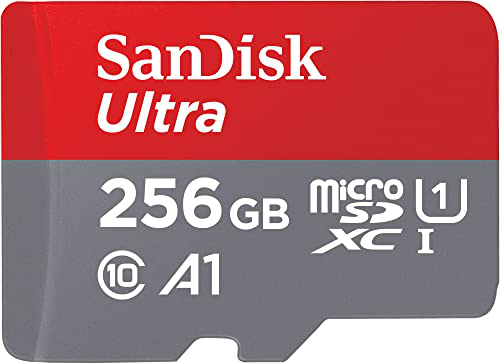

In [10]:
Image.open(img[0])

In [11]:
def get_features(dataset):
    all_features = []
    ids = []
    
    with torch.no_grad():
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model, preprocess = clip.load("ViT-B/32", device=device)
        for am_id, text in zip(dataset['id'].values, dataset['title'].values):
            text_tokens = clip.tokenize(text, truncate=True).to(device)
            features = model.encode_text(text_tokens)
            all_features.append(features)
            ids.append(am_id)
        for am_id, image_path in zip(dataset['id'].values, dataset['primary_image'].values):
            image_temp = r.urlretrieve(image_path)
            image = preprocess(Image.open(image_temp[0])).unsqueeze(0).to(device)
            features = model.encode_image(image)
            all_features.append(features)
            ids.append(am_id)

    return torch.cat(all_features).cpu().numpy(), ids

In [12]:
feats, ids = get_features(df)

In [13]:
torch.cuda.is_available()

True

In [14]:
type(feats)

numpy.ndarray

In [15]:
feats.shape

(200000, 512)

In [16]:
len(ids)

200000

In [17]:
np.save('clip_emb.npy', feats)

In [18]:
with open('clip_ids.json', 'w') as f:
    json.dump(ids, f)